In [ ]:
from urllib.request import urlretrieve
from PIL import Image
import os

import pandas as pd
import shutil
data_dir = '/content/diffusiondb-part-1-to-5'

In [ ]:

part_url = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/images/part-000001.zip'
urlretrieve(part_url, f'part-000001.zip')

part_url = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/images/part-000002.zip'
urlretrieve(part_url, f'part-000002.zip')

part_url = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/images/part-000003.zip'
urlretrieve(part_url, f'part-000003.zip')

part_url = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/images/part-000004.zip'
urlretrieve(part_url, f'part-000004.zip')

part_url = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/images/part-000005.zip'
urlretrieve(part_url, f'part-000005.zip')

('part-000005.zip', <http.client.HTTPMessage at 0x78255ea12200>)

In [ ]:
shutil.unpack_archive(f'/content/part-000001.zip', f'diffusiondb-part-1-to-5')
shutil.unpack_archive(f'/content/part-000002.zip', f'diffusiondb-part-1-to-5')
shutil.unpack_archive(f'/content/part-000003.zip', f'diffusiondb-part-1-to-5')
shutil.unpack_archive(f'/content/part-000004.zip', f'diffusiondb-part-1-to-5')
shutil.unpack_archive(f'/content/part-000005.zip', f'diffusiondb-part-1-to-5')

In [ ]:
os.remove(f'{data_dir}/part-000001.json')
os.remove(f'{data_dir}/part-000002.json')
os.remove(f'{data_dir}/part-000003.json')
os.remove(f'{data_dir}/part-000004.json')
os.remove(f'{data_dir}/part-000005.json')
len(os.listdir(data_dir))

5000

In [ ]:
metadata = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/metadata.parquet'
urlretrieve(metadata, f'metadata.parquet')

('metadata.parquet', <http.client.HTTPMessage at 0x7f566f162bc0>)

In [ ]:
metadata_df = pd.read_parquet('metadata.parquet')

In [ ]:
metadata_df[:5000]

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,42c9d8cc-9aff-4609-9f31-d273e2f5ef71.png,scarlet witch outfit concept art trending on a...,5,3750811694,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:46:00+00:00,0.552977,0.001335
4996,2aacf96e-4c92-45b2-bed3-62374bc918d3.png,[ angel - like ]!! scarlet witch outfit concep...,5,1111992836,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:49:00+00:00,0.824537,0.000505
4997,a6baf9ae-68d2-4517-afa7-0a6b4ec21a3f.png,[ obscenely corrupted dismally heathen - like ...,5,1344582638,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:54:00+00:00,0.394097,0.033509
4998,c7f83edb-3771-4ee6-9d0d-605fe45644c6.png,elizabeth olsen in a [ tenaciously witch - lik...,5,2755046587,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:59:00+00:00,0.141651,0.098639


In [ ]:
metadata_df = metadata_df[:5000]
nsfw_filtered = metadata_df.loc[(metadata_df['image_nsfw'] <= .6) & (
    metadata_df['prompt_nsfw'] <= .2)]
nsfw_filtered

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,a9efe85e-6a26-4fe5-91b1-eb4c52db2744.png,full body concept art of elizabeth olsen as sc...,5,1794915370,50,7.0,8,512,704,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:37:00+00:00,0.110999,0.000307
4995,42c9d8cc-9aff-4609-9f31-d273e2f5ef71.png,scarlet witch outfit concept art trending on a...,5,3750811694,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:46:00+00:00,0.552977,0.001335
4997,a6baf9ae-68d2-4517-afa7-0a6b4ec21a3f.png,[ obscenely corrupted dismally heathen - like ...,5,1344582638,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:54:00+00:00,0.394097,0.033509
4998,c7f83edb-3771-4ee6-9d0d-605fe45644c6.png,elizabeth olsen in a [ tenaciously witch - lik...,5,2755046587,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:59:00+00:00,0.141651,0.098639


### Rate image using aesthetic-scorer


In [ ]:
!git clone https://github.com/kenjiqq/aesthetics-scorer

Cloning into 'aesthetics-scorer'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 309 (delta 12), reused 21 (delta 5), pack-reused 263
Receiving objects: 100% (309/309), 373.88 MiB | 34.70 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Updating files: 100% (61/61), done.


In [ ]:
import torch
import torch.nn as nn
import json
import os


class AestheticScorer(nn.Module):
    def __init__(self, input_size=0, use_activation=False, dropout=0.2, config=None, hidden_dim=1024, reduce_dims=False, output_activation=None):
        super().__init__()
        self.config = {
            "input_size": input_size,
            "use_activation": use_activation,
            "dropout": dropout,
            "hidden_dim": hidden_dim,
            "reduce_dims": reduce_dims,
            "output_activation": output_activation
        }
        if config != None:
            self.config.update(config)

        layers = [
            nn.Linear(self.config["input_size"], self.config["hidden_dim"]),
            nn.ReLU() if self.config["use_activation"] else None,
            nn.Dropout(self.config["dropout"]),

            nn.Linear(self.config["hidden_dim"], round(
                self.config["hidden_dim"] / (2 if reduce_dims else 1))),
            nn.ReLU() if self.config["use_activation"] else None,
            nn.Dropout(self.config["dropout"]),

            nn.Linear(round(self.config["hidden_dim"] / (2 if reduce_dims else 1)), round(
                self.config["hidden_dim"] / (4 if reduce_dims else 1))),
            nn.ReLU() if self.config["use_activation"] else None,
            nn.Dropout(self.config["dropout"]),

            nn.Linear(round(self.config["hidden_dim"] / (4 if reduce_dims else 1)), round(
                self.config["hidden_dim"] / (8 if reduce_dims else 1))),
            nn.ReLU() if self.config["use_activation"] else None,
            nn.Linear(
                round(self.config["hidden_dim"] / (8 if reduce_dims else 1)), 1),
        ]
        if self.config["output_activation"] == "sigmoid":
            layers.append(
                nn.Sigmoid()
            )
        layers = [x for x in layers if x is not None]
        self.layers = nn.Sequential(
            *layers
        )

    def forward(self, x):
        if self.config["output_activation"] == "sigmoid":
            upper, lower = 10, 1
            scale = upper - lower
            return (self.layers(x) * scale) + lower
        else:
            return self.layers(x)

    def save(self, save_name):
        split_name = os.path.splitext(save_name)
        with open(f"{split_name[0]}.config", "w") as outfile:
            outfile.write(json.dumps(self.config, indent=4))

        for i in range(6):  # saving sometiles fails, so retry 5 times, might be windows issue
            try:
                torch.save(self.state_dict(), save_name)
                break
            except RuntimeError as e:
                # check if error contains string "File"
                if "cannot be opened" in str(e) and i < 5:
                    print("Model save failed, retrying...")
                else:
                    raise e


def preprocess(embeddings):
    return embeddings / embeddings.norm(p=2, dim=-1, keepdim=True)


def load_model(weight_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    split_path = os.path.splitext(weight_path)
    with open(f"{split_path[0]}.config", "r") as config_file:
        config = json.load(config_file)
    model = AestheticScorer(config=config)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    return model

In [ ]:
from transformers import CLIPModel, CLIPProcessor

MODEL = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CLIPModel.from_pretrained(MODEL)
vision_model = model.vision_model
vision_model.to(DEVICE)
del model
clip_processor = CLIPProcessor.from_pretrained(MODEL)

rating_model = load_model(
    "/content/aesthetics-scorer/aesthetics_scorer/models/aesthetics_scorer_rating_openclip_vit_h_14.pth").to(DEVICE)
artifacts_model = load_model(
    "/content/aesthetics-scorer/aesthetics_scorer/models/aesthetics_scorer_artifacts_openclip_vit_h_14.pth").to(DEVICE)


def predict(img):
    inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        vision_output = vision_model(**inputs)
    pooled_output = vision_output.pooler_output
    embedding = preprocess(pooled_output)
    with torch.no_grad():
        rating = rating_model(embedding)
        artifact = artifacts_model(embedding)
    return rating.detach().cpu().item(), artifact.detach().cpu().item()

In [ ]:
# def predict(img):
#     inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
#     with torch.no_grad():
#         vision_output = vision_model(**inputs)
#     pooled_output = vision_output.pooler_output
#     embedding = preprocess(pooled_output)
#     with torch.no_grad():
#         rating = rating_model(embedding)
#         artifact = artifacts_model(embedding)
#     return lambda x :x[0] ,rating.detach().cpu(), artifact.detach().cpu().tolist()

In [ ]:
# def rateImage(image_names):
#   images = []
#   for image_name in image_names:
#     images.append(Image.open(f'{data_dir}/{image_name}'))
#   return predict(images)

In [ ]:
# rateImage(['058d0e39-92f3-403c-8b64-8411b5062e82.png','92c488a0-4297-45c1-a001-76aee6399d30.png','ba37e532-41f6-46ef-a521-1dff30cfbce5.png','bcaacfc0-36ed-4de7-8ff7-1bf1f2912b79.png',])

([6.755103588104248, 6.750338554382324, 6.753666400909424, 6.753823757171631],
 [[2.256535053253174],
  [1.906059741973877],
  [1.967431664466858],
  [1.4544166326522827]])

In [ ]:
# test = metadata_df.loc[(metadata_df['image_nsfw'] <= .6) & (metadata_df['prompt_nsfw'] <= .2)]

In [ ]:
# test[:1000]['rating'], test[:1000]['artifact'] = rateImage(test[:1000]['image_name'])

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.94 GiB. GPU 0 has a total capacity of 14.75 GiB of which 257.06 MiB is free. Process 214945 has 14.49 GiB memory in use. Of the allocated memory 13.08 GiB is allocated by PyTorch, and 1.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def rateImage(image_names):
    ratings = []
    artifacts = []
    for image_name in image_names:
        rating, artifact = predict(Image.open(f'{data_dir}/{image_name}'))
        ratings.append(rating)
        artifacts.append(artifact)
    return ratings, artifacts

In [ ]:
nsfw_filtered['rating'], nsfw_filtered['artifact'] = rateImage(
    nsfw_filtered['image_name'])
nsfw_filtered

<ipython-input-99-33bc6a89729a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsfw_filtered['rating'], nsfw_filtered['artifact'] = rateImage(nsfw_filtered['image_name'])
<ipython-input-99-33bc6a89729a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsfw_filtered['rating'], nsfw_filtered['artifact'] = rateImage(nsfw_filtered['image_name'])


,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,rating,artifact
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621,6.856824,2.235459
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707,8.377316,1.797195
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425,8.935234,1.162502
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586,4.641343,2.360917
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822,4.435495,3.014965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,a9efe85e-6a26-4fe5-91b1-eb4c52db2744.png,full body concept art of elizabeth olsen as sc...,5,1794915370,50,7.0,8,512,704,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:37:00+00:00,0.110999,0.000307,3.916290,4.512863
4995,42c9d8cc-9aff-4609-9f31-d273e2f5ef71.png,scarlet witch outfit concept art trending on a...,5,3750811694,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:46:00+00:00,0.552977,0.001335,5.125982,2.754791
4997,a6baf9ae-68d2-4517-afa7-0a6b4ec21a3f.png,[ obscenely corrupted dismally heathen - like ...,5,1344582638,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:54:00+00:00,0.394097,0.033509,3.306830,3.971187
4998,c7f83edb-3771-4ee6-9d0d-605fe45644c6.png,elizabeth olsen in a [ tenaciously witch - lik...,5,2755046587,50,7.0,8,512,640,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:59:00+00:00,0.141651,0.098639,6.563005,2.461612


In [ ]:
nsfw_filtered.to_parquet(path='/content/Prompts-search/nsfw_filtered.parquet')

In [ ]:
nsfw_filtered = pd.read_parquet(
    '/content/Prompts-search/nsfw_filtered.parquet')

In [ ]:
aesthetics_filtered = nsfw_filtered.loc[(
    nsfw_filtered['rating'] >= 6.5) & (nsfw_filtered['artifact'] <= 2)]
aesthetics_filtered.drop_duplicates(subset=['image_name'])

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,rating,artifact
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707,8.377316,1.797195
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425,8.935234,1.162502
39,633ff0f9-b8b6-4232-a638-b17dc62ee972.png,a painting by edward hopper of a busy and bust...,1,1729868565,50,6.0,8,512,512,08ac4153ab7e13baa55ee74213eb117a29a0024267b29e...,2022-08-20 07:19:00+00:00,0.083464,0.004128,7.055211,1.087534
50,f3501e05-aef7-4225-a9e9-f516527408ac.png,"geodesic landscape, john chamberlain, christop...",1,38753269,50,12.0,8,640,512,0cffabb468fc6047499fb5f498012d24c984b113f22681...,2022-08-20 12:07:00+00:00,0.047901,0.000983,7.062381,1.511348
51,d650cde8-7990-4f70-9b21-e27b91f9d42f.png,art station octane sustainable modern village ...,1,2019116206,50,7.0,8,768,512,0d2323da0f71aa5cf2b94c64ab5fa524548ef12b1e1b57...,2022-08-20 10:03:00+00:00,0.094529,0.000827,7.776108,1.531609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4969,6251016d-f1aa-415e-ab86-c8d4d878f996.png,old - fashioned hotel bedroom from the 1 9 8 0...,5,3221392594,50,7.0,8,1024,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 20:18:00+00:00,0.222914,0.000465,6.740188,1.999986
4982,b04718a1-9f23-4553-a412-b541296b05c3.png,a wide shot angle of a tumultuous landscape ma...,5,4173240633,50,7.0,8,768,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 22:00:00+00:00,0.067111,0.000694,9.196033,1.047046
4983,31640c90-b39a-4297-99b6-443dd640fb33.png,a wide shot angle of a tumultuous landscape [ ...,5,2502520749,50,9.0,8,1024,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-18 22:02:00+00:00,0.060307,0.001202,8.263618,1.362485
4988,f96d12df-a2f3-454a-9305-c58543dbf41a.png,hawaiian laulau 4 k photorealism intricate pro...,5,2138551678,50,7.0,8,512,512,ffee0f4b6fd0fa325e9b53fab6f2098ff2c0414e6e0d99...,2022-08-19 03:09:00+00:00,0.076860,0.001814,7.593213,1.517203


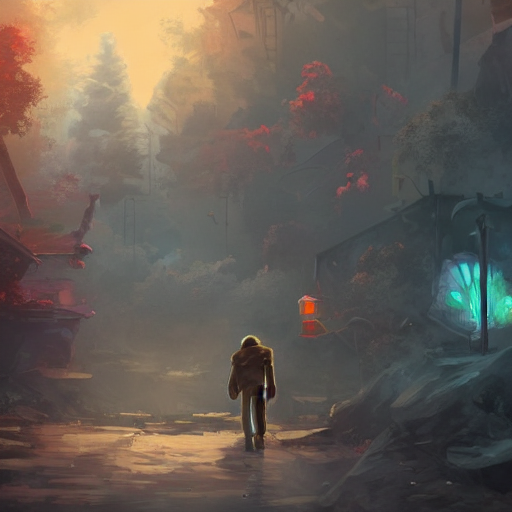

In [ ]:
Image.open(f'{data_dir}/dc71658a-5e4b-4dca-861a-e1535510348b.png')

### Add a new pandas column contain base64 encoded string of images


In [ ]:
import base64


def addImageBase64Column(row):
    with open(f"{data_dir}/{row['image_name']}", "rb") as image_file:
        return base64.b64encode(image_file.read()).decode()


aesthetics_filtered['image'] = aesthetics_filtered.apply(
    addImageBase64Column, axis=1)

<ipython-input-27-7da48d3bc0a3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aesthetics_filtered['image'] = aesthetics_filtered.apply(addImageBase64Column, axis=1)


In [ ]:
dropped = aesthetics_filtered.drop(['user_name', 'timestamp', 'image_nsfw',
                                   'prompt_nsfw', 'part_id', 'width', 'height', 'rating', 'artifact'], axis=1)
dropped['id'] = dropped['image_name'].str[:-4]
dropped

,image_name,prompt,seed,step,cfg,sampler,image,id
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,4231506957,50,7.0,8,iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...,c78807b7-d55a-4a2d-a6b6-9192b18941ad
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",544607824,50,7.0,8,iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...,dc71658a-5e4b-4dca-861a-e1535510348b
39,633ff0f9-b8b6-4232-a638-b17dc62ee972.png,a painting by edward hopper of a busy and bust...,1729868565,50,6.0,8,iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...,633ff0f9-b8b6-4232-a638-b17dc62ee972
50,f3501e05-aef7-4225-a9e9-f516527408ac.png,"geodesic landscape, john chamberlain, christop...",38753269,50,12.0,8,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAIAAACdH0qsAA...,f3501e05-aef7-4225-a9e9-f516527408ac
51,d650cde8-7990-4f70-9b21-e27b91f9d42f.png,art station octane sustainable modern village ...,2019116206,50,7.0,8,iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAA...,d650cde8-7990-4f70-9b21-e27b91f9d42f
...,...,...,...,...,...,...,...,...
4969,6251016d-f1aa-415e-ab86-c8d4d878f996.png,old - fashioned hotel bedroom from the 1 9 8 0...,3221392594,50,7.0,8,iVBORw0KGgoAAAANSUhEUgAABAAAAAIACAIAAACTr4nuAA...,6251016d-f1aa-415e-ab86-c8d4d878f996
4982,b04718a1-9f23-4553-a412-b541296b05c3.png,a wide shot angle of a tumultuous landscape ma...,4173240633,50,7.0,8,iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAA...,b04718a1-9f23-4553-a412-b541296b05c3
4983,31640c90-b39a-4297-99b6-443dd640fb33.png,a wide shot angle of a tumultuous landscape [ ...,2502520749,50,9.0,8,iVBORw0KGgoAAAANSUhEUgAABAAAAAIACAIAAACTr4nuAA...,31640c90-b39a-4297-99b6-443dd640fb33
4988,f96d12df-a2f3-454a-9305-c58543dbf41a.png,hawaiian laulau 4 k photorealism intricate pro...,2138551678,50,7.0,8,iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAA...,f96d12df-a2f3-454a-9305-c58543dbf41a


### Export to JSON


In [ ]:
with open(f'/content/diffusiondb-part-1-to-5-with-base64-images-full.jsonl', 'w') as f:
    json_full = dropped.to_json(orient='records', lines=True)
    f.write(json_full)

In [ ]:
with open(f'/content/20-images.jsonl', 'w') as f:
    test_json = dropped[:20].to_json(orient='records', lines=True)
    f.write(test_json)

### Create a zip file of filtered images


In [1]:
import shutil

In [ ]:
for image_name in dropped['id']:
    shutil.copy2(f"{data_dir}/{image_name}",
                 f'/content/diffusiondb-images/{image_name}')
len(os.listdir('/content/diffusiondb-images'))

In [ ]:
shutil.make_archive('/content/Prompts-search/diffusiondb-images',
                    'zip', '/content/diffusiondb-images')